In [1]:
import time
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from qutip import bloch_redfield_tensor, QobjEvo

from plotstyle import init_style, COLORS
init_style()

from qspectro2d.config import SCRIPTS_DIR

# Updated spectroscopy calculation imports
from qspectro2d.spectroscopy.calculations import (
    parallel_compute_1d_E_with_inhomogenity,
    compute_1d_polarization,
    extract_ift_signal_component,
)
from qspectro2d.spectroscopy import compute_2d_fft_wavenumber

# Visualization (updated centralized helpers)
from qspectro2d.visualization import (
    plot_example_evo,
    plot_example_polarization,
    plot_2d_el_field,
)

# Utilities (updated path after refactor)
from qspectro2d.utils import (
    save_data_file,
    save_info_file,
    generate_unique_data_filename,
)
from qspectro2d.config import create_base_sim_oqs

# Core simulation + system components (new module locations)
from qspectro2d.core.simulation import SimulationConfig, SimulationModuleOQS
from qspectro2d.core.atomic_system.system_class import AtomicSystem
from qspectro2d.core.laser_system.laser_class import LaserPulseSequence
from qspectro2d.core.bath_system import extract_bath_parameters

In [2]:
config_path = SCRIPTS_DIR / "config.yaml"
# Build base simulation (applies CLI overrides inside)
sim_oqs, time_cut = create_base_sim_oqs(config_path=str(config_path) if config_path else None)

🔧 Base simulation created from config (overrides applied early).
🔍 Validating solver...
############################################################
✅ Solver validation worked: Evolution becomes unphysical at (inf × t_max)


<string>:16: UserWarning: rwa_sl forced True for Paper_eqs solver.


In [3]:
system = sim_oqs.system
bath = sim_oqs.bath
laser = sim_oqs.laser
w0 = system._frequencies_fs[0]
bath_dict = extract_bath_parameters(bath)
laser_dict = {k: v for k, v in laser.to_dict().items() if k != "pulses"}  # Exclude "pulses" key
dict_combined = {**system.to_dict(), **bath_dict, **laser_dict}

print(bath_dict)

{'T': 1e-06, 'temp': 1e-06, 'tag': 'ohmic', 'S(0)': 2e-08, 'alpha': 0.01, 'wc': 100.0, 'cutoff': 100.0, 's': 1.0}


RWA (rwa_sl) True


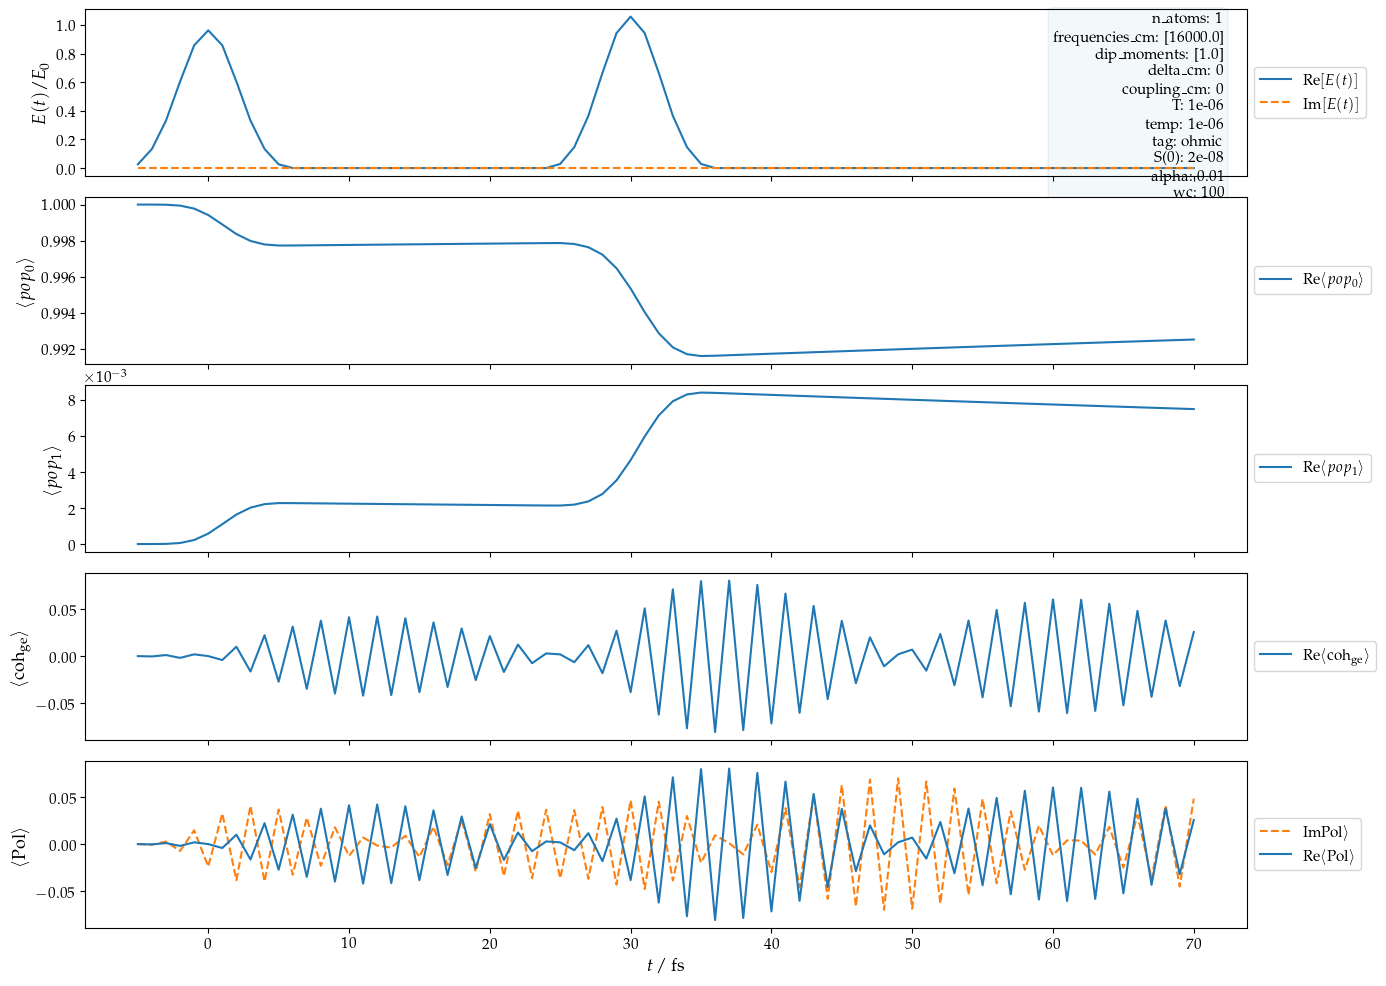

In [4]:
times, datas, sim_oqs = compute_1d_polarization(sim_oqs=sim_oqs, plot_example_evo=True, dipole_op = True)
rwa_sl = sim_oqs.simulation_config.rwa_sl
print(f"RWA (rwa_sl)", rwa_sl)
fig_evo = plot_example_evo(times, datas, sim_oqs.laser, rwa_sl=rwa_sl, observable_strs=sim_oqs.observable_strs, **dict_combined)
display(fig_evo)


--- Processing t_coh = 0.0 fs (1/5) ---
RWA (rwa_sl) True


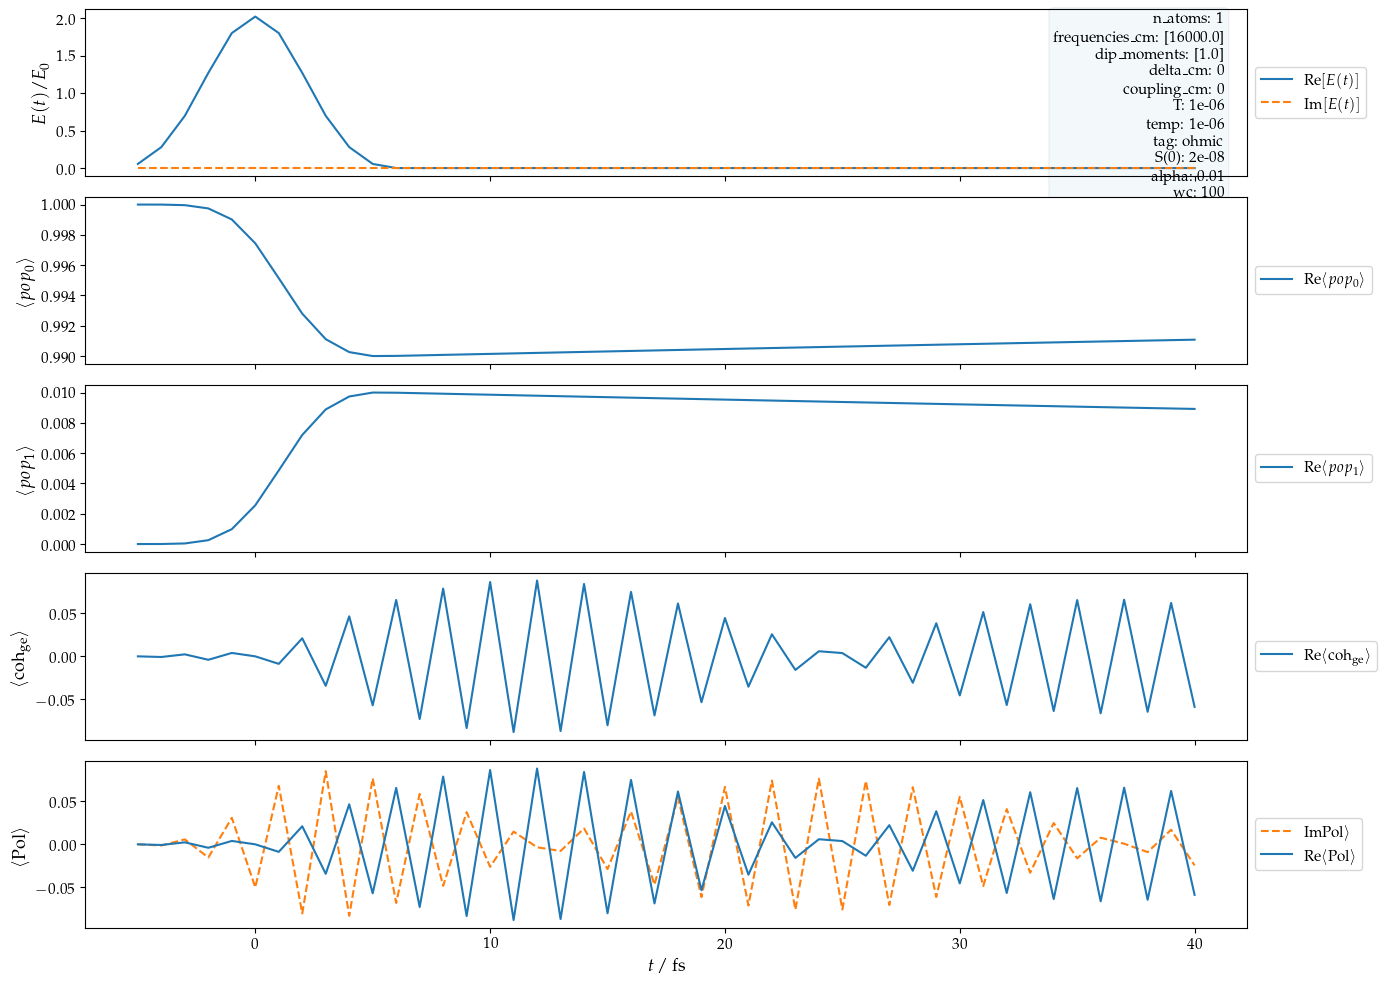


--- Processing t_coh = 10.0 fs (2/5) ---
RWA (rwa_sl) True


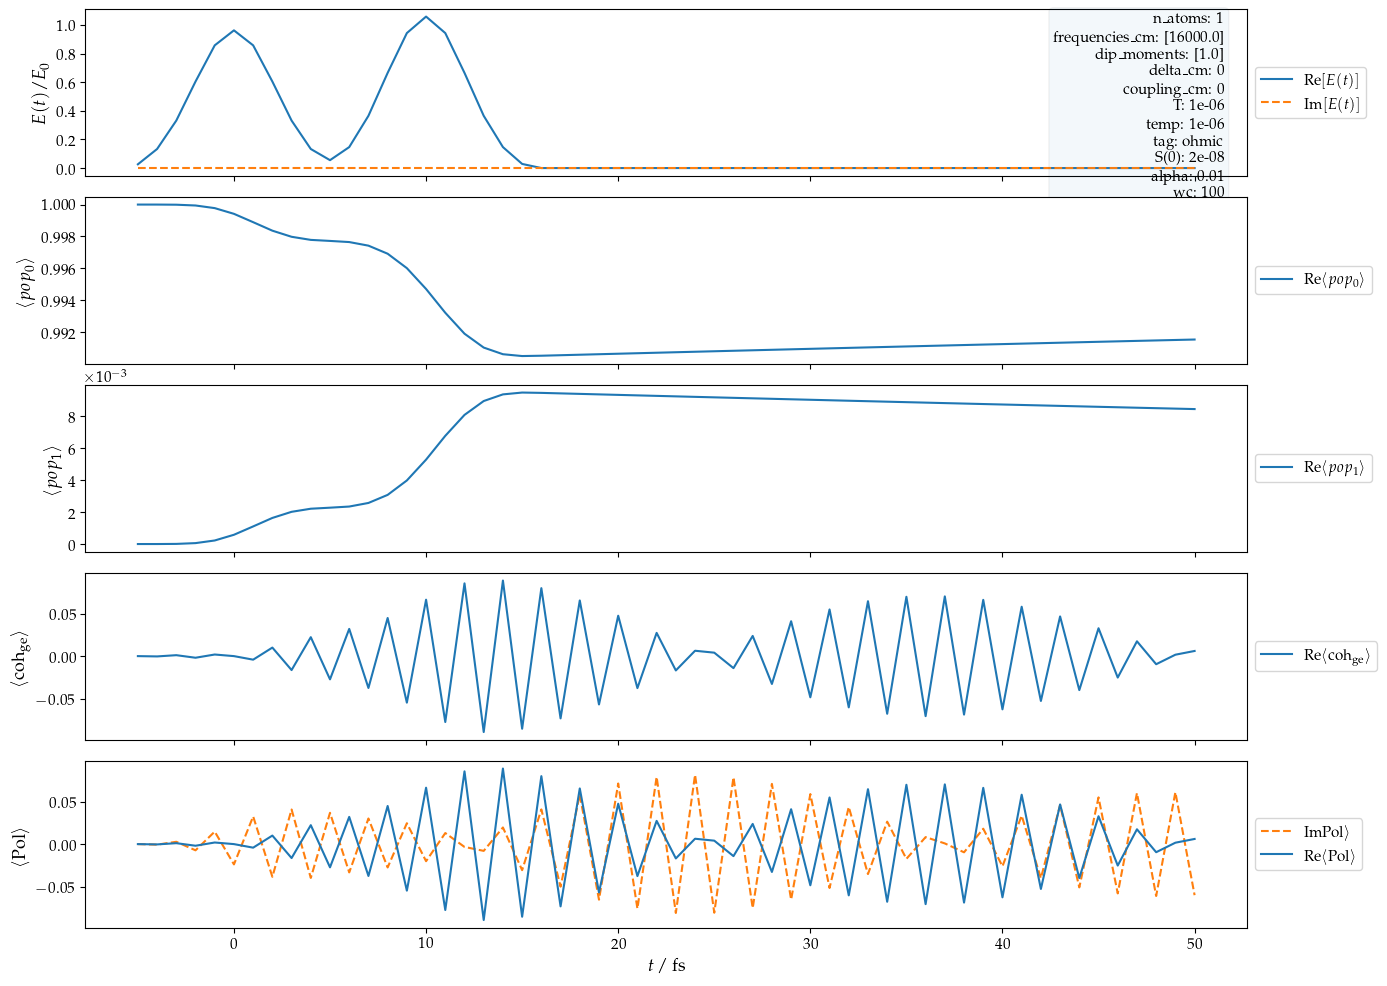


--- Processing t_coh = 20.0 fs (3/5) ---
RWA (rwa_sl) True


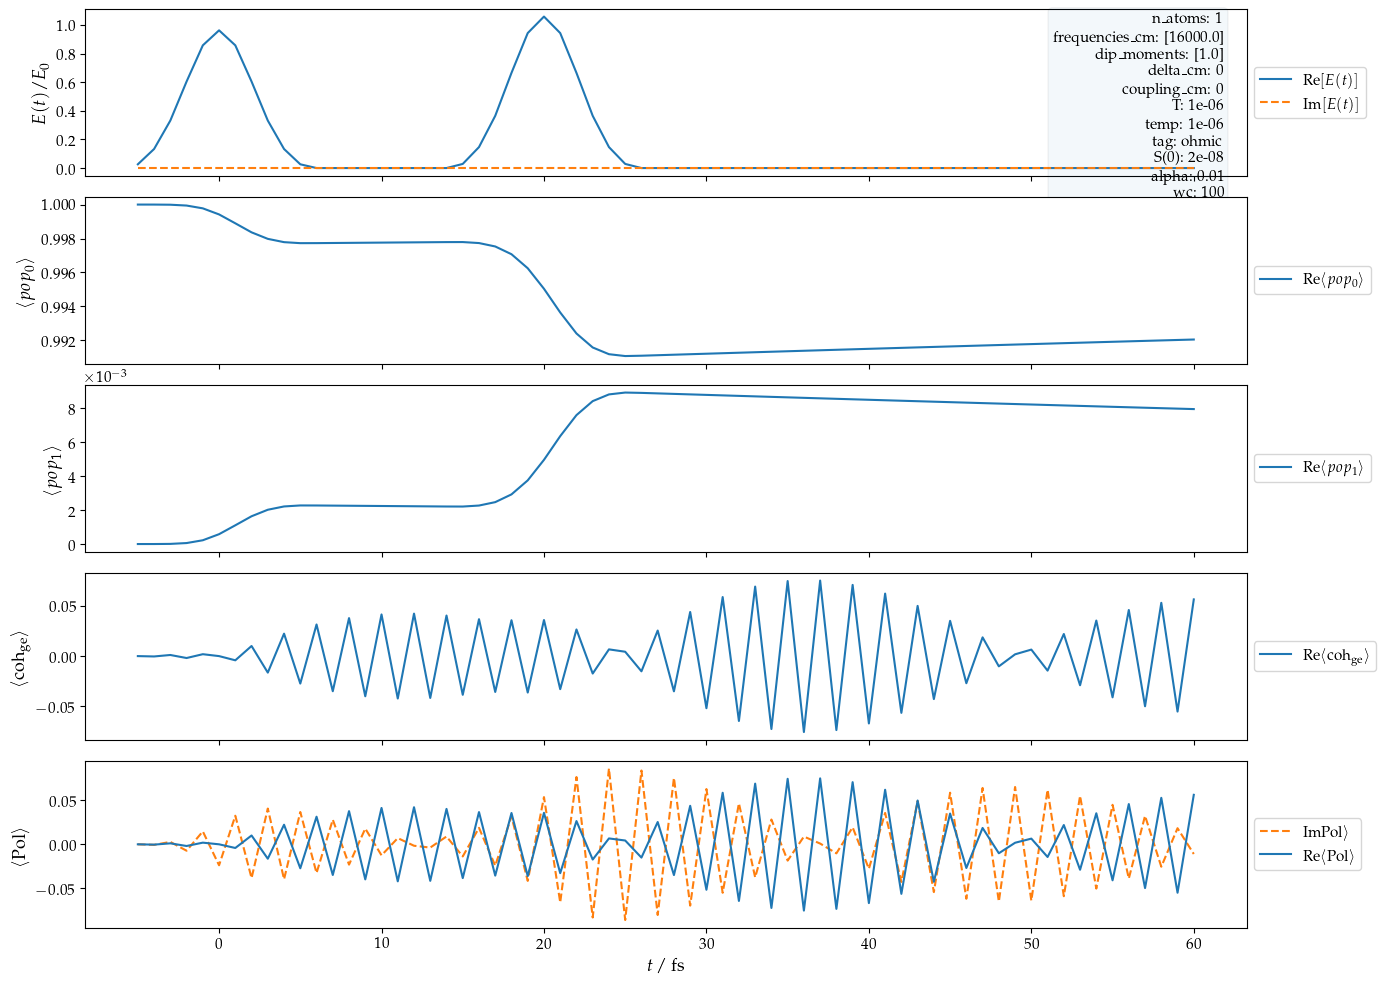


--- Processing t_coh = 30.0 fs (4/5) ---
RWA (rwa_sl) True


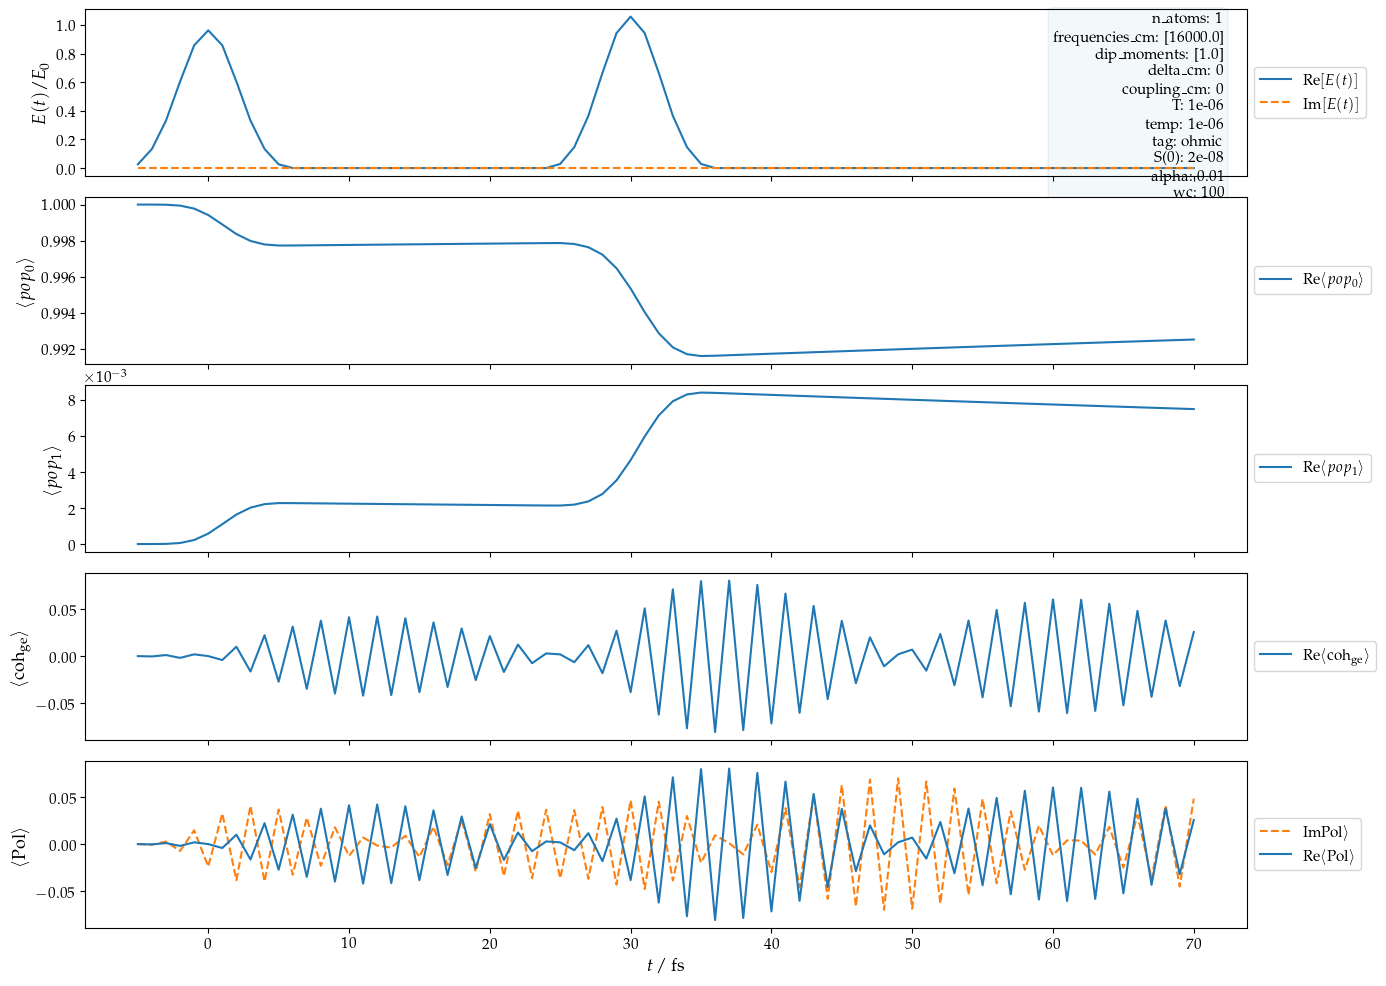


--- Processing t_coh = 40.0 fs (5/5) ---
RWA (rwa_sl) True


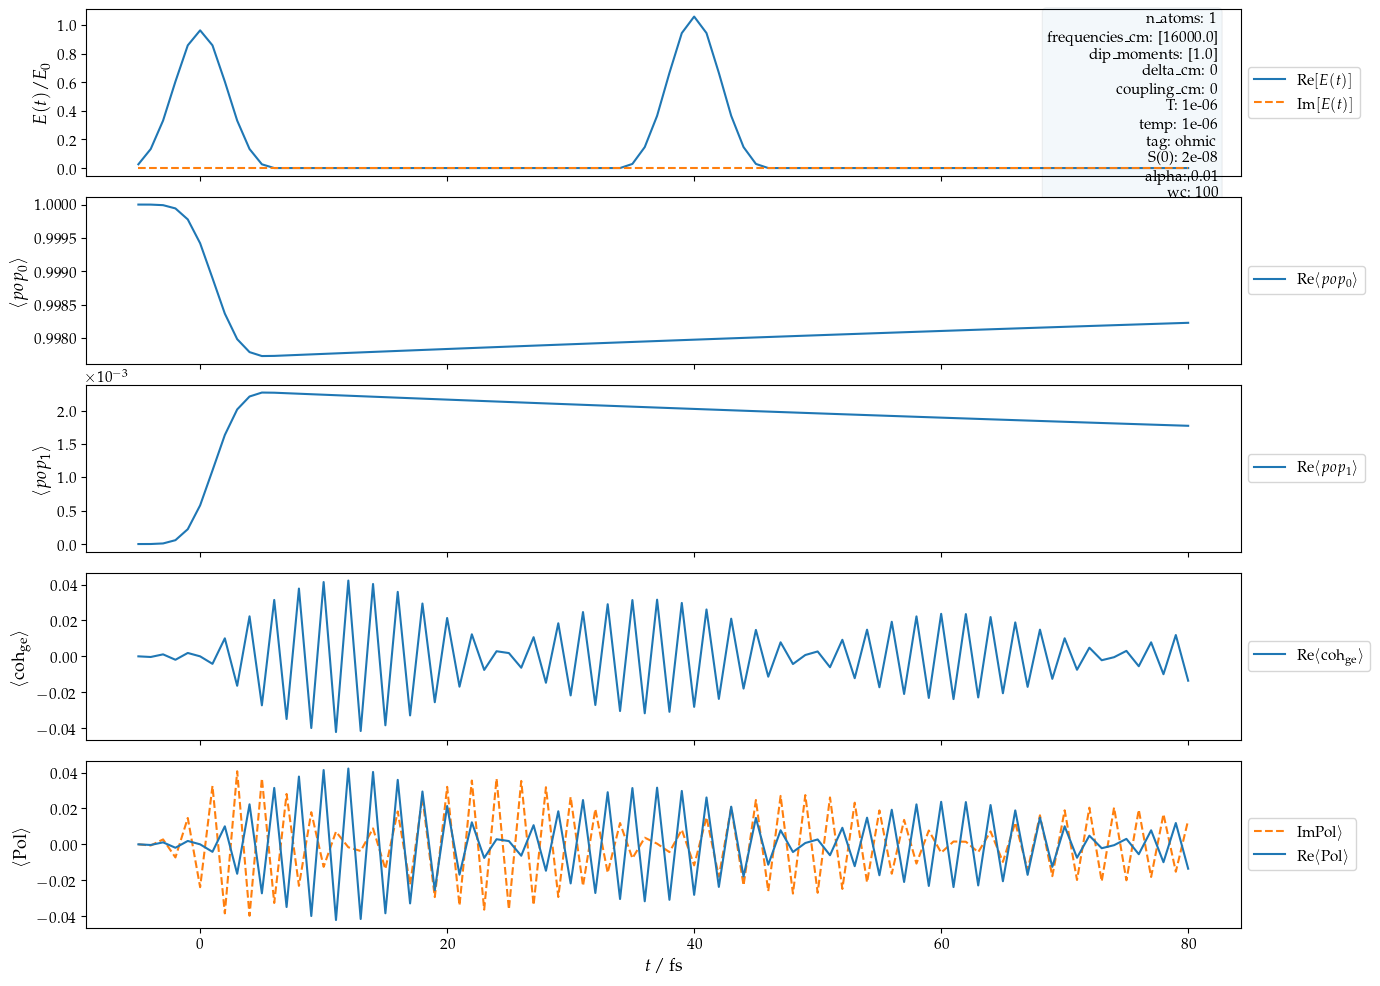

In [5]:
t_coh_range = sim_oqs.times_det
rwa_sl = sim_oqs.simulation_config.rwa_sl

# Store results for each t_coh
results_matrices_2d = {}
signal_components_2d = {}

start_time_2d = time.time()

for i, t_coh in enumerate(t_coh_range[::10]):
    print(f"\n--- Processing t_coh = {t_coh:.1f} fs ({i+1}/{len(t_coh_range[::10])}) ---")
    
    # Update t_coh in the simulation config
    sim_config_obj = sim_oqs.simulation_config
    original_t_coh = sim_config_obj.t_coh
    sim_config_obj.t_coh = t_coh
    t_wait = sim_config_obj.t_wait
    t_det_max = sim_config_obj.t_det_max
    sim_config_obj.t_max = t_wait + 2 * t_det_max

    # Clear cached global / local time arrays so they rebuild with new t_max
    if hasattr(sim_oqs, "_times_global"):
        delattr(sim_oqs, "_times_global")
    sim_oqs.reset_times_local()
    
    sim_oqs.laser.update_delays([t_coh, t_wait])  # Note hard to extend to n pulses

    times, datas, sim_oqs = compute_1d_polarization(sim_oqs=sim_oqs, plot_example_evo=True, dipole_op=True)
    print(f"RWA (rwa_sl)", rwa_sl)
    fig_evo = plot_example_evo(times, datas, sim_oqs.laser, rwa_sl=rwa_sl, observable_strs=sim_oqs.observable_strs, **dict_combined)
    display(fig_evo)



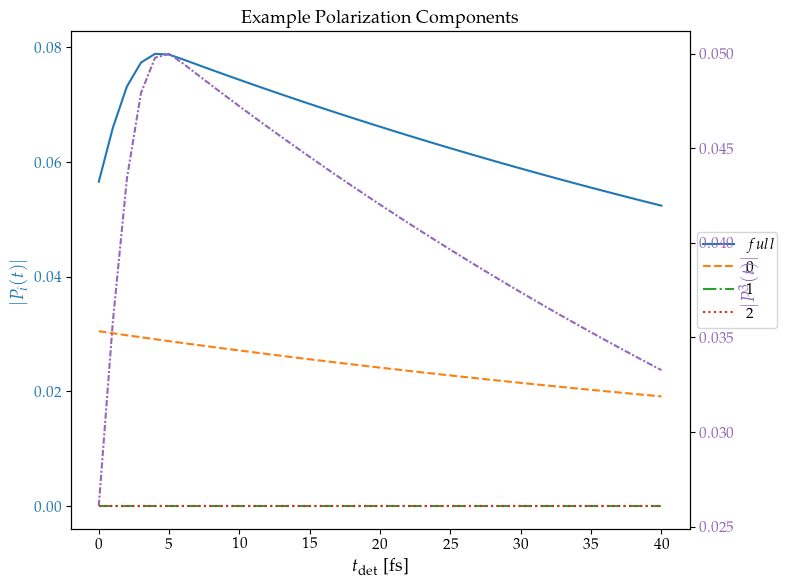

In [6]:
plot_data = compute_1d_polarization(sim_oqs, time_cut=time_cut, plot_example_polarization = True)
P_full, P_only0, P_only1, P_only2 = plot_data
times = sim_oqs.times_det

pulse_seq = sim_oqs.laser
rwa_sl = sim_oqs.simulation_config.rwa_sl
observable_strs = sim_oqs.observable_strs

plot_example_polarization(times, P_full, P_only0, P_only1, P_only2)

## Step-by-step spectroscopy workflow

This section recreates the logic of `calc_datas.py` but broken into small, testable steps so you can visually validate physics after each stage:

1. Inspect / visualize pulse sequence (envelope, RWA field, full field).
2. Validate solver stability (extended evolution) and obtain `time_cut`.
3. **STEP 3a**: Compute raw results matrix (phase-resolved polarization matrix) for single t_coh.
4. **STEP 3b**: Extract IFT signal components from the results matrix for single t_coh.
5. **STEP 3a-2D**: Compute raw results matrix for multiple coherence times (2D simulation).
6. **STEP 3b-2D**: Extract IFT signal components for multiple coherence times.
7. Transform and inspect frequency-domain representation (1D and 2D).
8. (Optional) Scan multiple coherence times to progressively assemble a 2D data set with live partial visualization.
9. Save intermediate / final results (NPZ + info) using the usual I/O helpers.

Adjust parameters at the top of each code cell to iterate quickly. Each code cell is independent where possible to encourage experimentation.

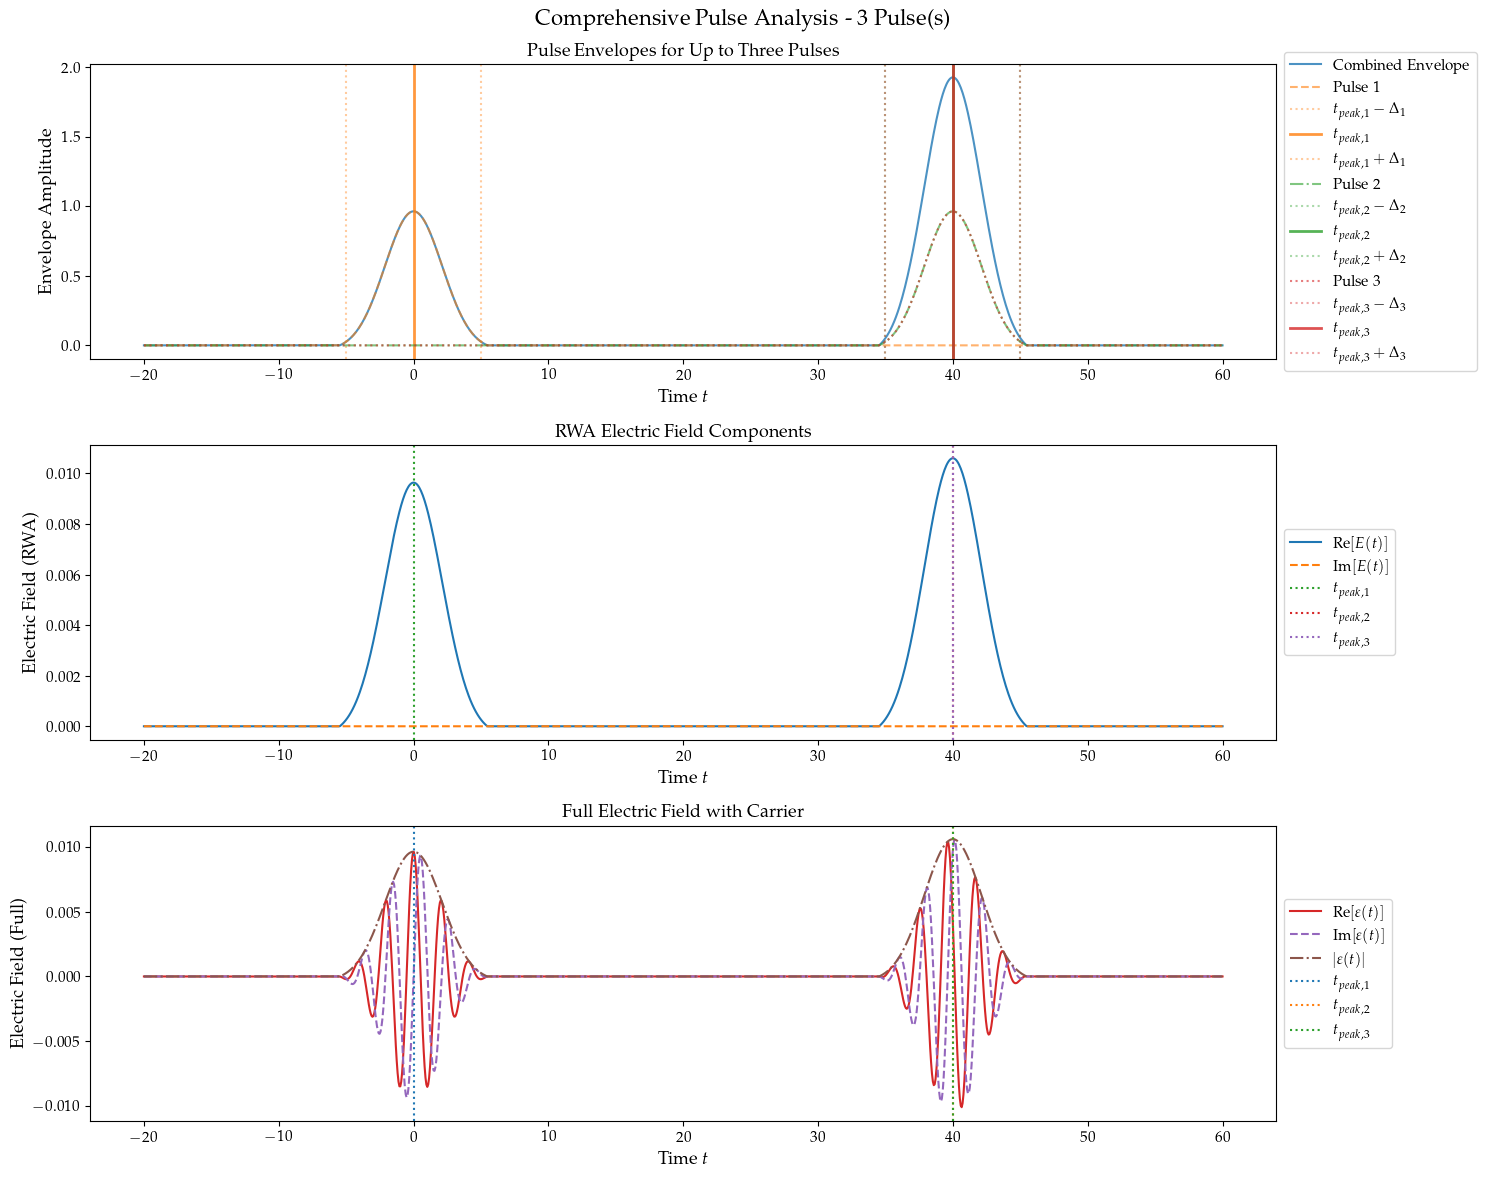

In [7]:
# STEP 1: Inspect and visualize pulse sequence
# You can re-run this after changing the config or modifying delays.
from qspectro2d.visualization.plotting import plot_all_pulse_components

_times_pulse = np.linspace(
    -4 * sim_oqs.laser.pulse_fwhms[0],
    sim_oqs.simulation_config.t_coh + sim_oqs.simulation_config.t_wait + 4 * sim_oqs.laser.pulse_fwhms[0],
    1200,
)

fig_pulses = plot_all_pulse_components(_times_pulse, sim_oqs.laser)
display(fig_pulses)

In [8]:
# STEP 2: Solver validation (extended evolution)
# Re-runs validation to get (possibly) updated time_cut threshold for instability.
from qspectro2d.spectroscopy.solver_check import check_the_solver

res_val, time_cut_new = check_the_solver(sim_oqs)
print(f"time_cut (old) = {time_cut:.3f} fs, time_cut (new) = {time_cut_new:.3f} fs")
# Keep the stricter (earlier) cutoff for safety
time_cut = min(time_cut, time_cut_new) if time_cut != -np.inf else time_cut_new
print(f"Using time_cut = {time_cut:.3f} fs for subsequent truncations (if finite).")

time_cut (old) = inf fs, time_cut (new) = inf fs
Using time_cut = inf fs for subsequent truncations (if finite).


Running 1D simulation at t_coh = 40.00 fs
Computing phase-resolved polarization matrix...
Results matrix shape: (4, 4, 41)
Matrix contains 0 NaN values


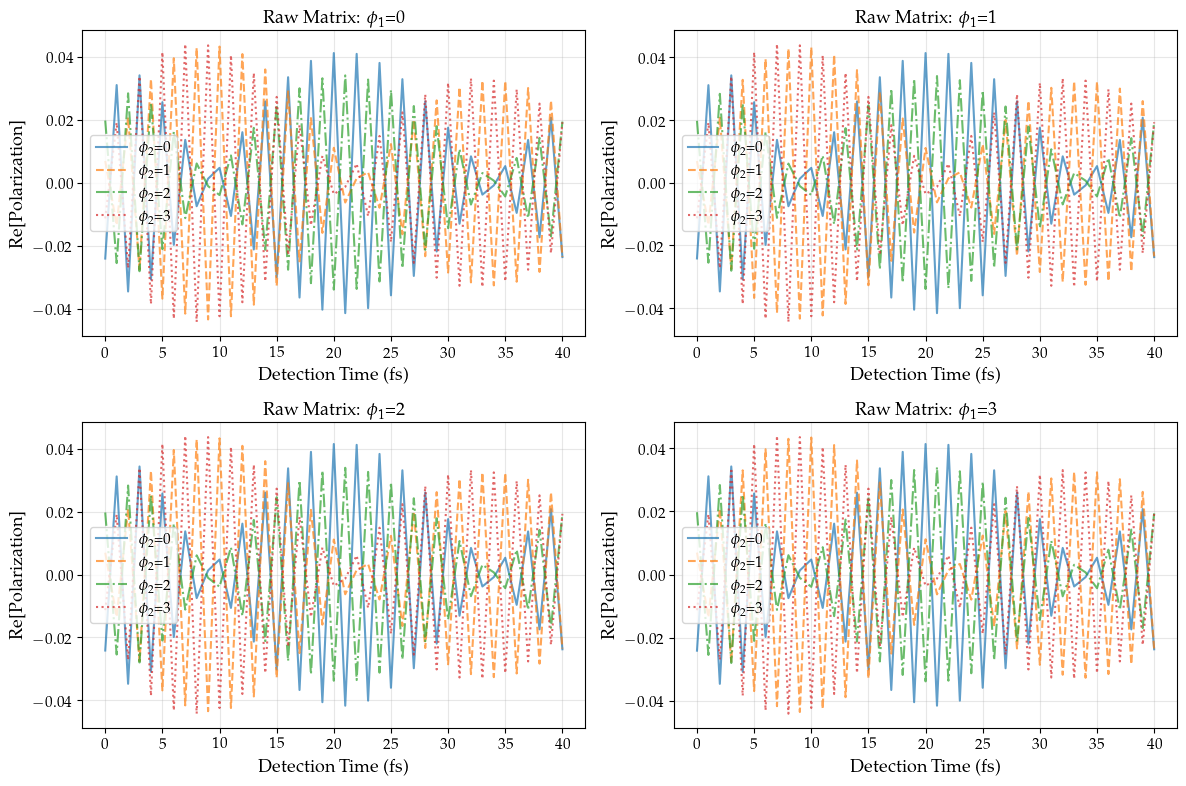

Raw results matrix computed and visualized.


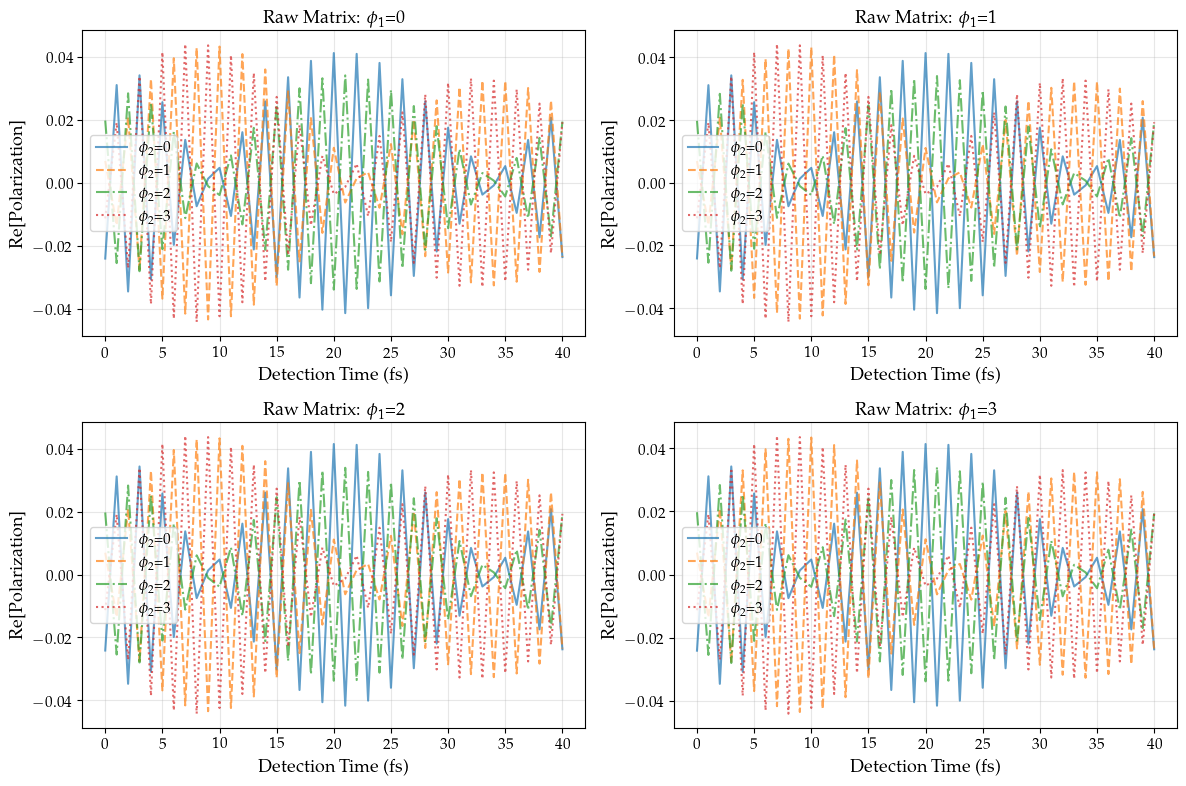

In [9]:
# STEP 3a: Compute raw results matrix (phase-resolved polarization)
# This performs all expensive solver calls and returns the averaged nonlinear polarization matrix
from qspectro2d.spectroscopy.calculations import compute_1d_pol_matrix_phases

print(f"Running 1D simulation at t_coh = {sim_oqs.simulation_config.t_coh:.2f} fs")
print("Computing phase-resolved polarization matrix...")

# Compute the raw results matrix (this is the expensive part)
Pol_matrix_phases = compute_1d_pol_matrix_phases(sim_oqs=sim_oqs, time_cut=time_cut)

print(f"Results matrix shape: {Pol_matrix_phases.shape}")
print(f"Matrix contains {np.isnan(Pol_matrix_phases).sum()} NaN values")

# Plot a slice of the raw results matrix (e.g., phi1=0, all phi2)
_times_det = sim_oqs.times_det
n_phases = sim_oqs.simulation_config.n_phases

fig_matrix = plt.figure(figsize=(12, 8))
for phi1_idx in range(min(4, n_phases)):  # Show first 4 phi1 values
    plt.subplot(2, 2, phi1_idx + 1)
    for phi2_idx in range(n_phases):
        plt.plot(_times_det, np.real(Pol_matrix_phases[phi1_idx, phi2_idx, :]),
                label=f'$\phi_2$={phi2_idx}', c=COLORS[phi2_idx], alpha=0.7)
    plt.xlabel('Detection Time (fs)')
    plt.ylabel('Re[Polarization]')
    plt.title(f'Raw Matrix: $\phi_1$={phi1_idx}')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
display(fig_matrix)

print("Raw results matrix computed and visualized.")

Extracting IFT signal components...
Extracted signal components: ['average']
Final _datas list contains 1 components


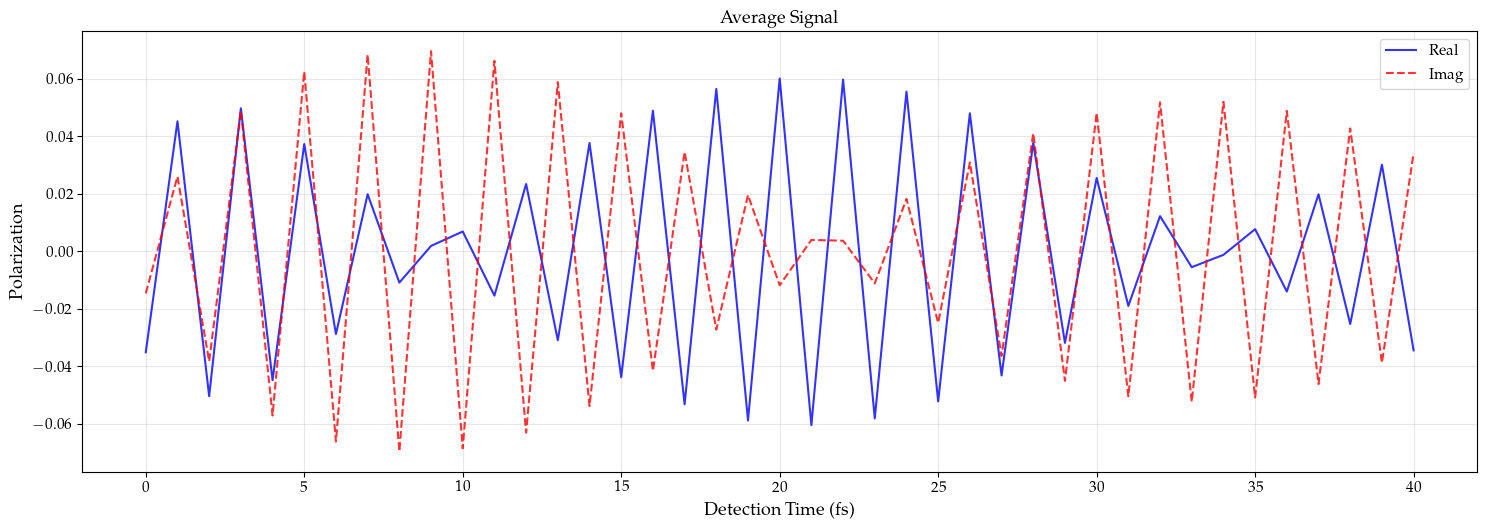

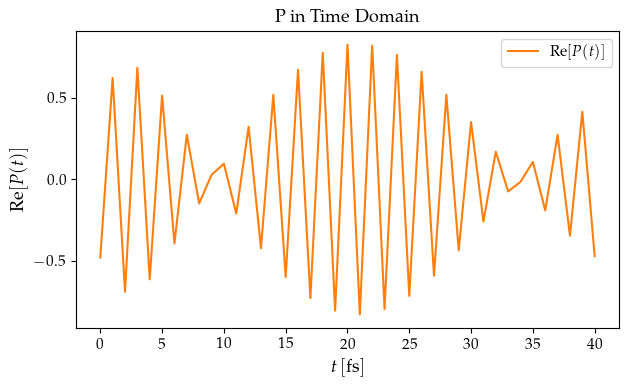

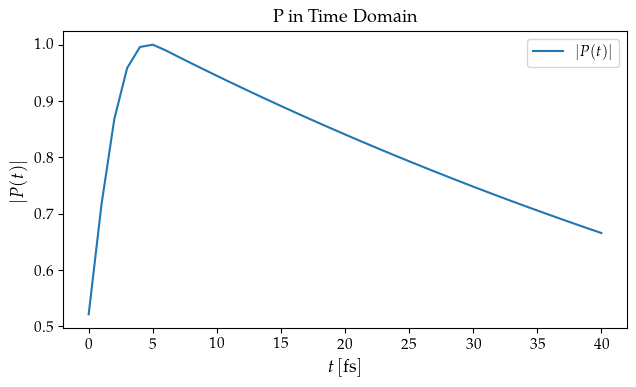

IFT signal components extracted and visualized.


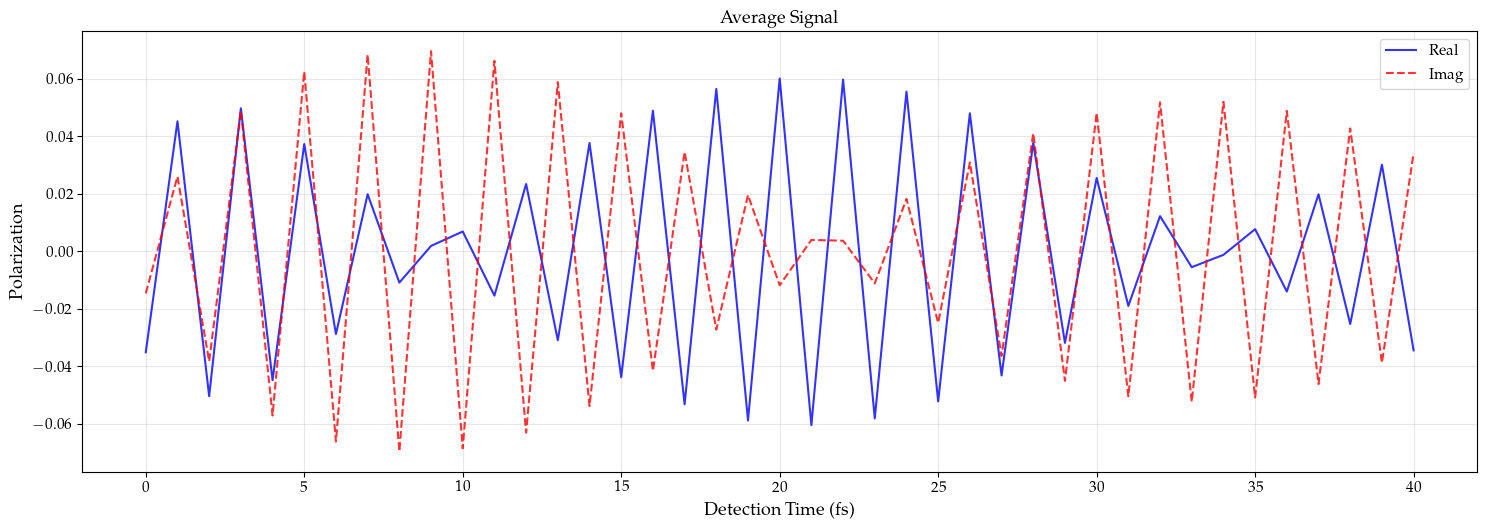

In [10]:
# STEP 3b: Extract IFT signal components from the results matrix
from qspectro2d.spectroscopy.calculations import extract_P_lmn_1d
from qspectro2d.visualization.plotting import plot_1d_el_field

print("Extracting IFT signal components...")

# Extract the signal components using inverse Fourier transform
signal_components = extract_P_lmn_1d(Pol_matrix_phases, sim_oqs)

print(f"Extracted signal components: {list(signal_components.keys())}")

# Now create the final _datas list (same format as original function)
_datas = [signal_components[sig] for sig in sim_oqs.simulation_config.signal_types if sig in signal_components]

print(f"Final _datas list contains {len(_datas)} components")

# Visualize the extracted signal components
_times_det = sim_oqs.times_det

fig_components = plt.figure(figsize=(15, 10))
n_components = len(_datas)

for i, (sig_type, component_data) in enumerate(zip(sim_oqs.simulation_config.signal_types, _datas)):
    plt.subplot(2, (n_components + 1) // 2, i + 1)
    
    # Plot real and imaginary parts
    plt.plot(_times_det, np.real(component_data), 'b-', label='Real', alpha=0.8)
    plt.plot(_times_det, np.imag(component_data), 'r--', label='Imag', alpha=0.8)
    
    plt.xlabel('Detection Time (fs)')
    plt.ylabel('Polarization')
    plt.title(f'{sig_type.capitalize()} Signal')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
display(fig_components)

if _datas:
    _pol = _datas[0]  # First component (usually rephasing)
    fig_1d_real = plot_1d_el_field(_times_det, _pol, domain='time', component='real', function_symbol='P')
    fig_1d_abs = plot_1d_el_field(_times_det, _pol, domain='time', component='abs', function_symbol='P')
    
    display(fig_1d_real)
    display(fig_1d_abs)

print("IFT signal components extracted and visualized.")

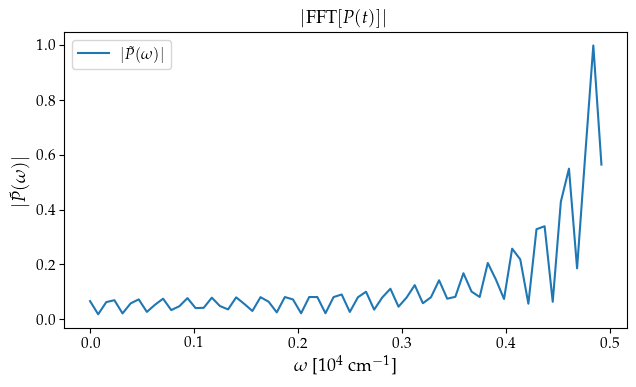

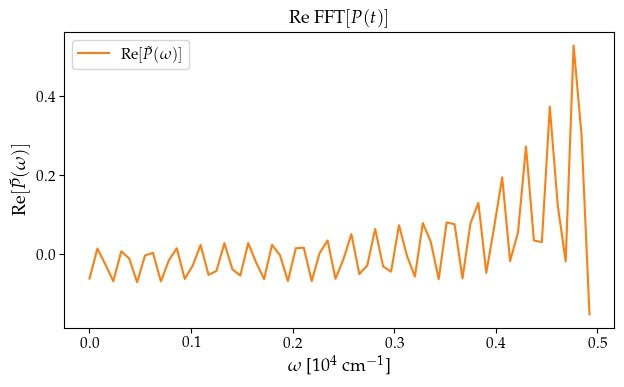

In [11]:
# STEP 4: Frequency-domain view of the single 1D signal
# Apply FFT with simple zero-padding (optional) for better interpolation.
_pad_factor = 2
N = len(_pol)
N_pad = int(2 ** np.ceil(np.log2(N * _pad_factor)))
_pol_padded = np.zeros(N_pad, dtype=complex)
_pol_padded[:N] = _pol
# Frequency axis (cycles / fs)
_dt = np.diff(_times_det).mean()
_freq = np.fft.fftfreq(N_pad, d=_dt)
FFT = np.fft.fft(_pol_padded)
# Keep only positive branch for plotting
pos_mask = _freq >= 0
_freq_pos = _freq[pos_mask]
FFT_pos = FFT[pos_mask]
# STEP 4: Frequency-domain view of the single 1D signal
# Apply FFT with simple zero-padding (optional) for better interpolation.
_pad_factor = 2
N = len(_pol)
N_pad = int(2 ** np.ceil(np.log2(N * _pad_factor)))
_pol_padded = np.zeros(N_pad, dtype=complex)
_pol_padded[:N] = _pol
# Frequency axis (cycles / fs)
_dt = np.diff(_times_det).mean()
_freq = np.fft.fftfreq(N_pad, d=_dt)
FFT = np.fft.fft(_pol_padded)
# Keep only positive branch for plotting
pos_mask = _freq >= 0
_freq_pos = _freq[pos_mask]
FFT_pos = FFT[pos_mask]

fig_fft_abs = plot_1d_el_field(_freq_pos, FFT_pos, domain='freq', component='abs', function_symbol=r'\tilde{P}', title=r'$|\mathrm{FFT}[P(t)]|$')
fig_fft_real = plot_1d_el_field(_freq_pos, FFT_pos, domain='freq', component='real', function_symbol=r'\tilde{P}', title=r'$\mathrm{Re}\ \mathrm{FFT}[P(t)]$')

# Display the figures
display(fig_fft_abs)
display(fig_fft_real)

In [12]:
# STEP 3a-2D: Compute raw results matrix for multiple coherence times (2D simulation)
# This performs the expensive solver calls for multiple t_coh values to build the 2D dataset
from qspectro2d.spectroscopy.calculations import compute_1d_pol_matrix_phases

# Define range of coherence times for 2D simulation
t_coh_range = sim_oqs.times_det
print(f"Running 2D simulation with {len(t_coh_range)} coherence times: [{t_coh_range[0]:.1f}, {t_coh_range[-1]:.1f}] fs")

# Store results for each t_coh
results_matrices_2d = {}
signal_components_2d = {}

start_time_2d = time.time()

for i, t_coh in enumerate(t_coh_range):
    print(f"\n--- Processing t_coh = {t_coh:.1f} fs ({i+1}/{len(t_coh_range)}) ---")
    
    # Update t_coh in the simulation config
    sim_config_obj = sim_oqs.simulation_config
    original_t_coh = sim_config_obj.t_coh
    sim_config_obj.t_coh = t_coh
    t_wait = sim_config_obj.t_wait
    t_det_max = sim_config_obj.t_det_max
    sim_config_obj.t_max = t_wait + 2 * t_det_max

    # Clear cached global / local time arrays so they rebuild with new t_max
    if hasattr(sim_oqs, "_times_global"):
        delattr(sim_oqs, "_times_global")
    sim_oqs.reset_times_local()
    
    sim_oqs.laser.update_delays([t_coh, t_wait])  # Note hard to extend to n pulses

    # Compute the raw results matrix for this t_coh
    Pol_matrix_phases = compute_1d_pol_matrix_phases(sim_oqs=sim_oqs, time_cut=time_cut)
    results_matrices_2d[t_coh] = Pol_matrix_phases
    
    print(f"Results matrix shape: {Pol_matrix_phases.shape}")

# Restore original t_coh
sim_config_obj.t_coh = original_t_coh
sim_oqs.laser.update_delays([original_t_coh, sim_config_obj.t_wait])

elapsed_time_2d = time.time() - start_time_2d
print(f"\n✅ 2D raw results matrices computed in {elapsed_time_2d:.2f} seconds")
print(f"Total matrices stored: {len(results_matrices_2d)}")

Running 2D simulation with 41 coherence times: [0.0, 40.0] fs

--- Processing t_coh = 0.0 fs (1/41) ---
Results matrix shape: (4, 4, 41)

--- Processing t_coh = 1.0 fs (2/41) ---
Results matrix shape: (4, 4, 41)

--- Processing t_coh = 2.0 fs (3/41) ---
Results matrix shape: (4, 4, 41)

--- Processing t_coh = 3.0 fs (4/41) ---
Results matrix shape: (4, 4, 41)

--- Processing t_coh = 4.0 fs (5/41) ---
Results matrix shape: (4, 4, 41)

--- Processing t_coh = 5.0 fs (6/41) ---
Results matrix shape: (4, 4, 41)

--- Processing t_coh = 6.0 fs (7/41) ---
Results matrix shape: (4, 4, 41)

--- Processing t_coh = 7.0 fs (8/41) ---
Results matrix shape: (4, 4, 41)

--- Processing t_coh = 8.0 fs (9/41) ---
Results matrix shape: (4, 4, 41)

--- Processing t_coh = 9.0 fs (10/41) ---
Results matrix shape: (4, 4, 41)

--- Processing t_coh = 10.0 fs (11/41) ---
Results matrix shape: (4, 4, 41)

--- Processing t_coh = 11.0 fs (12/41) ---
Results matrix shape: (4, 4, 41)

--- Processing t_coh = 12.0 fs (

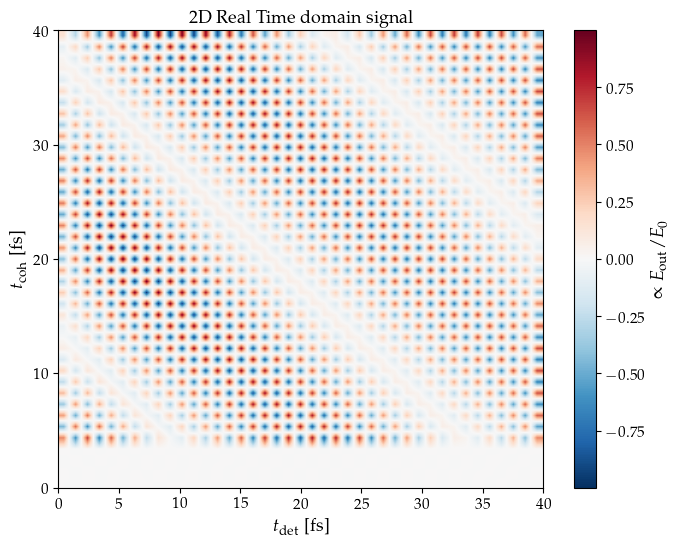

In [13]:
dummy_phi1_idx = 3
dummy_phi2_idx = 1
data_2d_raw = np.array([results_matrices_2d[t_coh][dummy_phi1_idx, dummy_phi2_idx, :] for t_coh in t_coh_range])
# Plot real part
fig_2d_real = plot_2d_el_field(
    t_coh_range, 
    t_coh_range, 
    data_2d_raw,  # Example: phi1=0, phi2=0 slice
    domain='time', 
    component='real',
)
display(fig_2d_real)

2D raw results matrices computed and visualized for start, middle, and end coherence times.


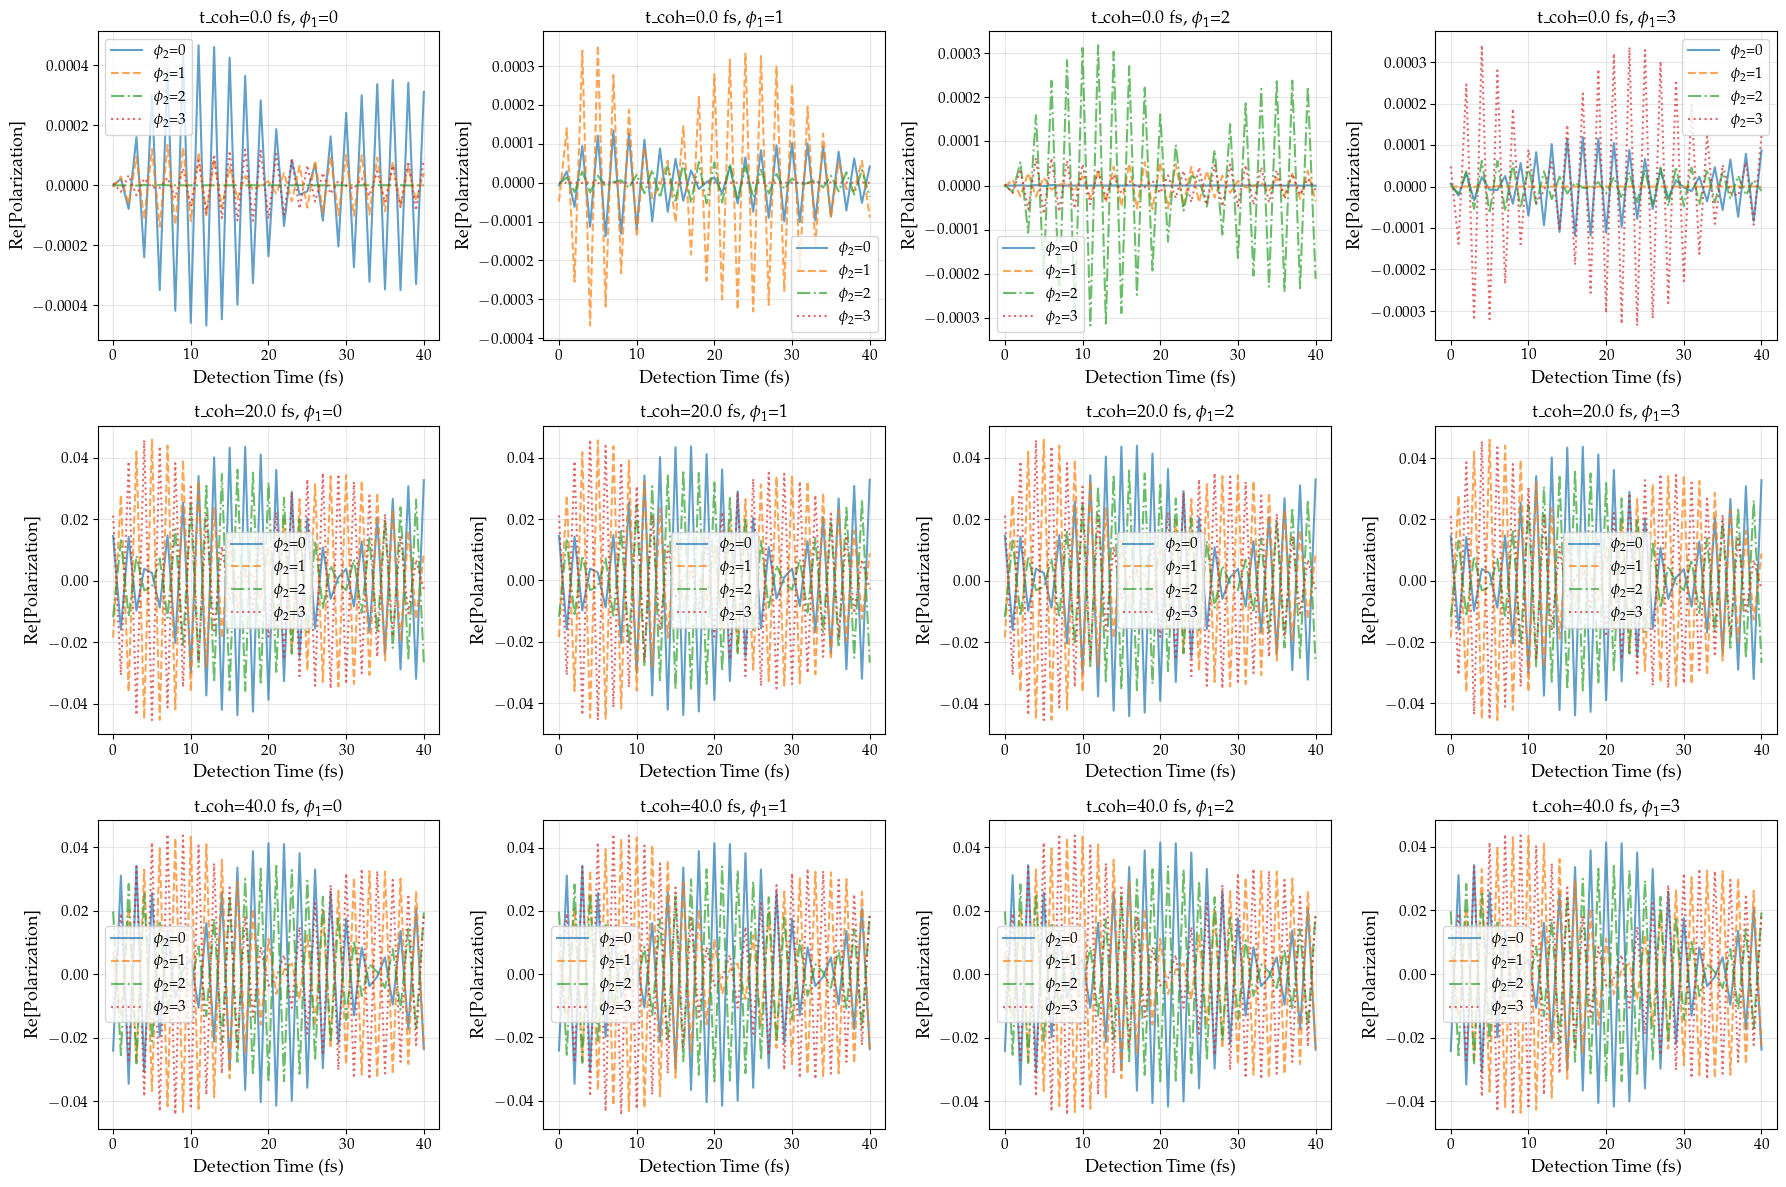

In [14]:
# Quick visualization of 3 slices at the start, middle, and end of t_coh_range
# Select three representative coherence times
t_coh_indices = [0, len(t_coh_range)//2, -1]  # start, middle, end
t_coh_samples = [t_coh_range[i] for i in t_coh_indices]
sample_matrices = [results_matrices_2d[t_coh] for t_coh in t_coh_samples]

fig_matrix_2d = plt.figure(figsize=(18, 12))
plot_idx = 1

for slice_idx, (t_coh, matrix) in enumerate(zip(t_coh_samples, sample_matrices)):
    for phi1_idx in range(min(4, sim_oqs.simulation_config.n_phases)):
        plt.subplot(3, 4, plot_idx)  # 3 rows (t_coh slices) x 4 columns (phi1 values)
        
        for phi2_idx in range(sim_oqs.simulation_config.n_phases):
            plt.plot(_times_det, np.real(matrix[phi1_idx, phi2_idx, :]),
                    label=f'$\phi_2$={phi2_idx}', c=COLORS[phi2_idx], alpha=0.7)
        
        plt.xlabel('Detection Time (fs)')
        plt.ylabel('Re[Polarization]')
        plt.title(f't_coh={t_coh:.1f} fs, $\phi_1$={phi1_idx}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plot_idx += 1

plt.tight_layout()

print("2D raw results matrices computed and visualized for start, middle, and end coherence times.")

Extracted signal components for 41 coherence times
Created 2D data arrays with shape (41, 41) for signal types: ['average']


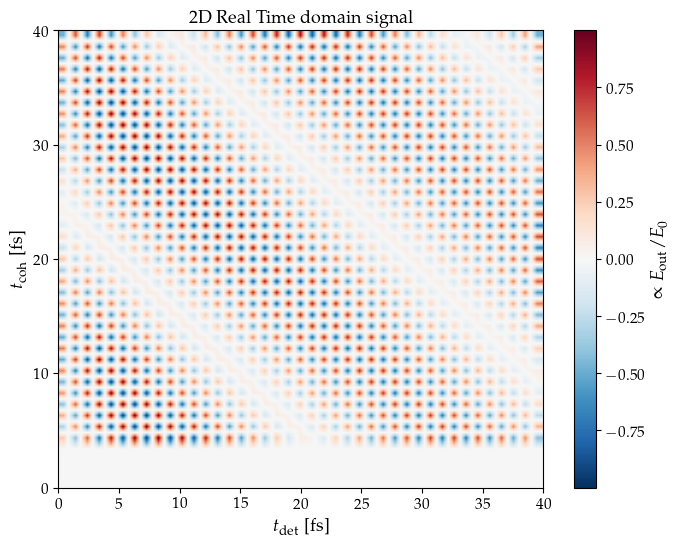

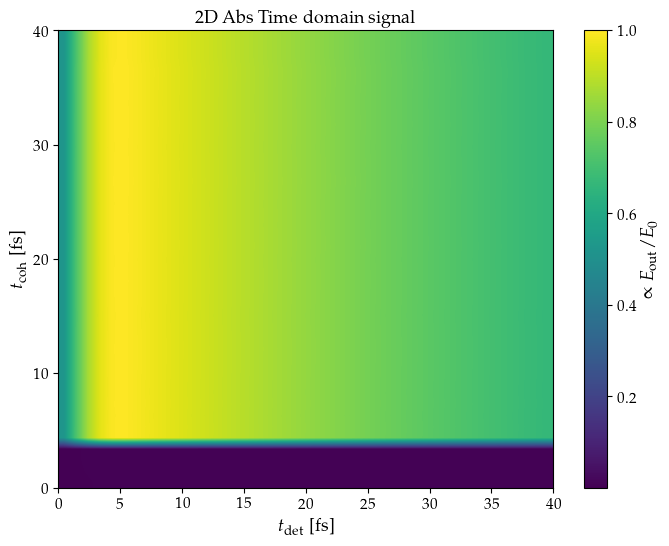

Transforming 2D time-domain data to frequency domain...
Frequency domain spectrum shape: (41, 41)
Detection wavenumber range: [-1.6, 1.6] × 10^4 cm⁻¹
Coherence wavenumber range: [-1.6, 1.6] × 10^4 cm⁻¹
Plotting 2D frequency-domain spectrum...


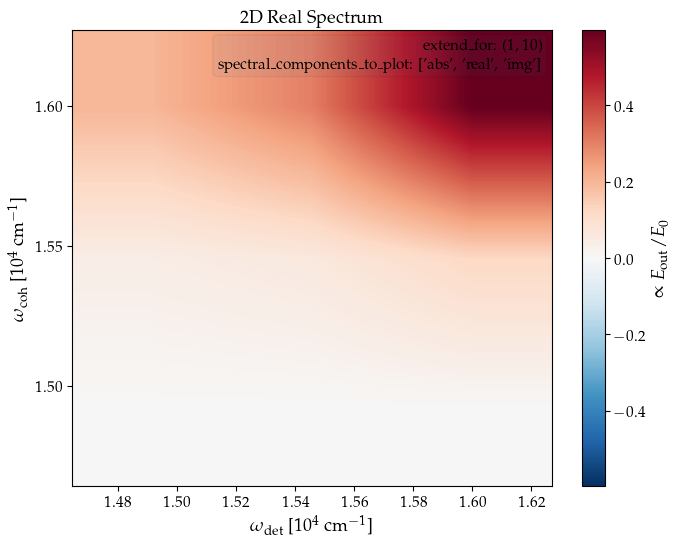

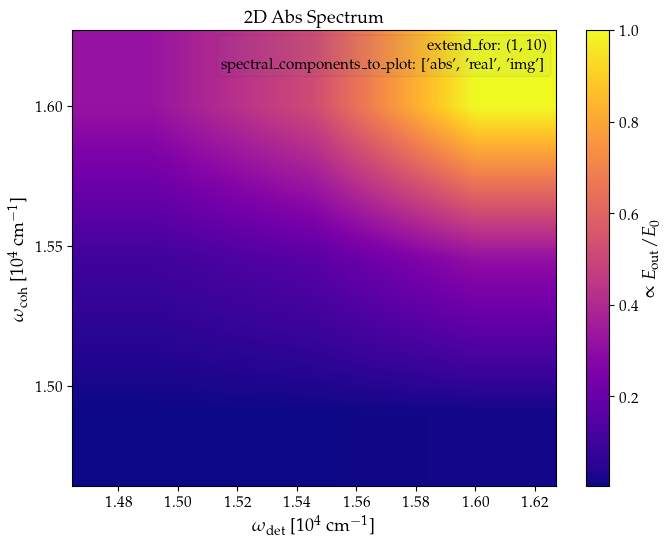

2D frequency-domain spectrum computed and visualized.


<Figure size 1500x1200 with 0 Axes>

In [15]:
# here i just want the average plotted
# STEP 3b-2D: Extract IFT signal (BUT JUST average) components for multiple coherence times
for t_coh in t_coh_range:
    results_matrix = results_matrices_2d[t_coh]
    signal_components = extract_P_lmn_1d(results_matrix, sim_oqs)
    signal_components_2d[t_coh] = signal_components

print(f"Extracted signal components for {len(signal_components_2d)} coherence times")

# Organize data for 2D plotting
signal_types = sim_oqs.simulation_config.signal_types
n_t_coh = len(t_coh_range)
n_t_det = len(_times_det)

# Create 2D arrays: (t_coh, t_det) for each signal type
data_2d = {}
for sig_type in signal_types:
    data_2d[sig_type] = np.zeros((n_t_coh, n_t_det), dtype=complex)
    for i, t_coh in enumerate(t_coh_range):
        data_2d[sig_type][i, :] = signal_components_2d[t_coh][sig_type]

print(f"Created 2D data arrays with shape ({n_t_coh}, {n_t_det}) for signal types: {list(data_2d.keys())}")

# Visualize signal components at a few coherence times
fig_components_2d = plt.figure(figsize=(15, 12))
sample_indices = [0, len(t_coh_range)//4, len(t_coh_range)//2, 3*len(t_coh_range)//4, -1]

# Show 2D contour plot for one signal type using plot_2d_el_field
if signal_types:
    primary_sig = signal_types[0]
    
    # Plot real part
    fig_2d_real = plot_2d_el_field(
        _times_det, 
        t_coh_range, 
        data_2d[primary_sig], 
        domain='time', 
        component='real',
    )
    display(fig_2d_real)
    
    # Plot absolute value
    fig_2d_abs = plot_2d_el_field(
        _times_det, 
        t_coh_range, 
        data_2d[primary_sig], 
        domain='time', 
        component='abs',
    )
    display(fig_2d_abs)

# STEP 5: Transform to frequency domain using compute_2d_fft_wavenumber
from qspectro2d.spectroscopy.post_processing import compute_2d_fft_wavenumber

print("Transforming 2D time-domain data to frequency domain...")

# Prepare data for FFT - convert dictionary to list in correct order
data_list = [data_2d[sig] for sig in signal_types]

# Compute 2D FFT
nu_dets, nu_cohs, spectrum_2d = compute_2d_fft_wavenumber(
    t_dets=_times_det,
    t_cohs=t_coh_range,
    datas=data_list,
    signal_types=signal_types
)

print(f"Frequency domain spectrum shape: {spectrum_2d.shape}")
print(f"Detection wavenumber range: [{nu_dets.min():.1f}, {nu_dets.max():.1f}] × 10^4 cm⁻¹")
print(f"Coherence wavenumber range: [{nu_cohs.min():.1f}, {nu_cohs.max():.1f}] × 10^4 cm⁻¹")

# Plot the 2D frequency-domain spectrum
print("Plotting 2D frequency-domain spectrum...")
plot_config = {
    # "plot_time_domain": True,
    "extend_for": (1, 10),
    "spectral_components_to_plot": ["abs", "real", "img"],
    # "section": [(1, 3), (1, 3)],
    "section": [(1.4, 1.8), (1.4, 1.8)],
}

# Plot real part in frequency domain
fig_2d_freq_real = plot_2d_el_field(
    nu_dets, 
    nu_cohs, 
    spectrum_2d, 
    domain='freq', 
    component='real',
    **plot_config
)
display(fig_2d_freq_real)

# Plot absolute value in frequency domain
fig_2d_freq_abs = plot_2d_el_field(
    nu_dets, 
    nu_cohs, 
    spectrum_2d, 
    domain='freq', 
    component='abs',
    **plot_config

)
display(fig_2d_freq_abs)

print("2D frequency-domain spectrum computed and visualized.")

Extracting IFT signal components for 2D simulation...
Extracted signal components for 41 coherence times
Created 2D data arrays with shape (41, 41) for signal types: ['average']


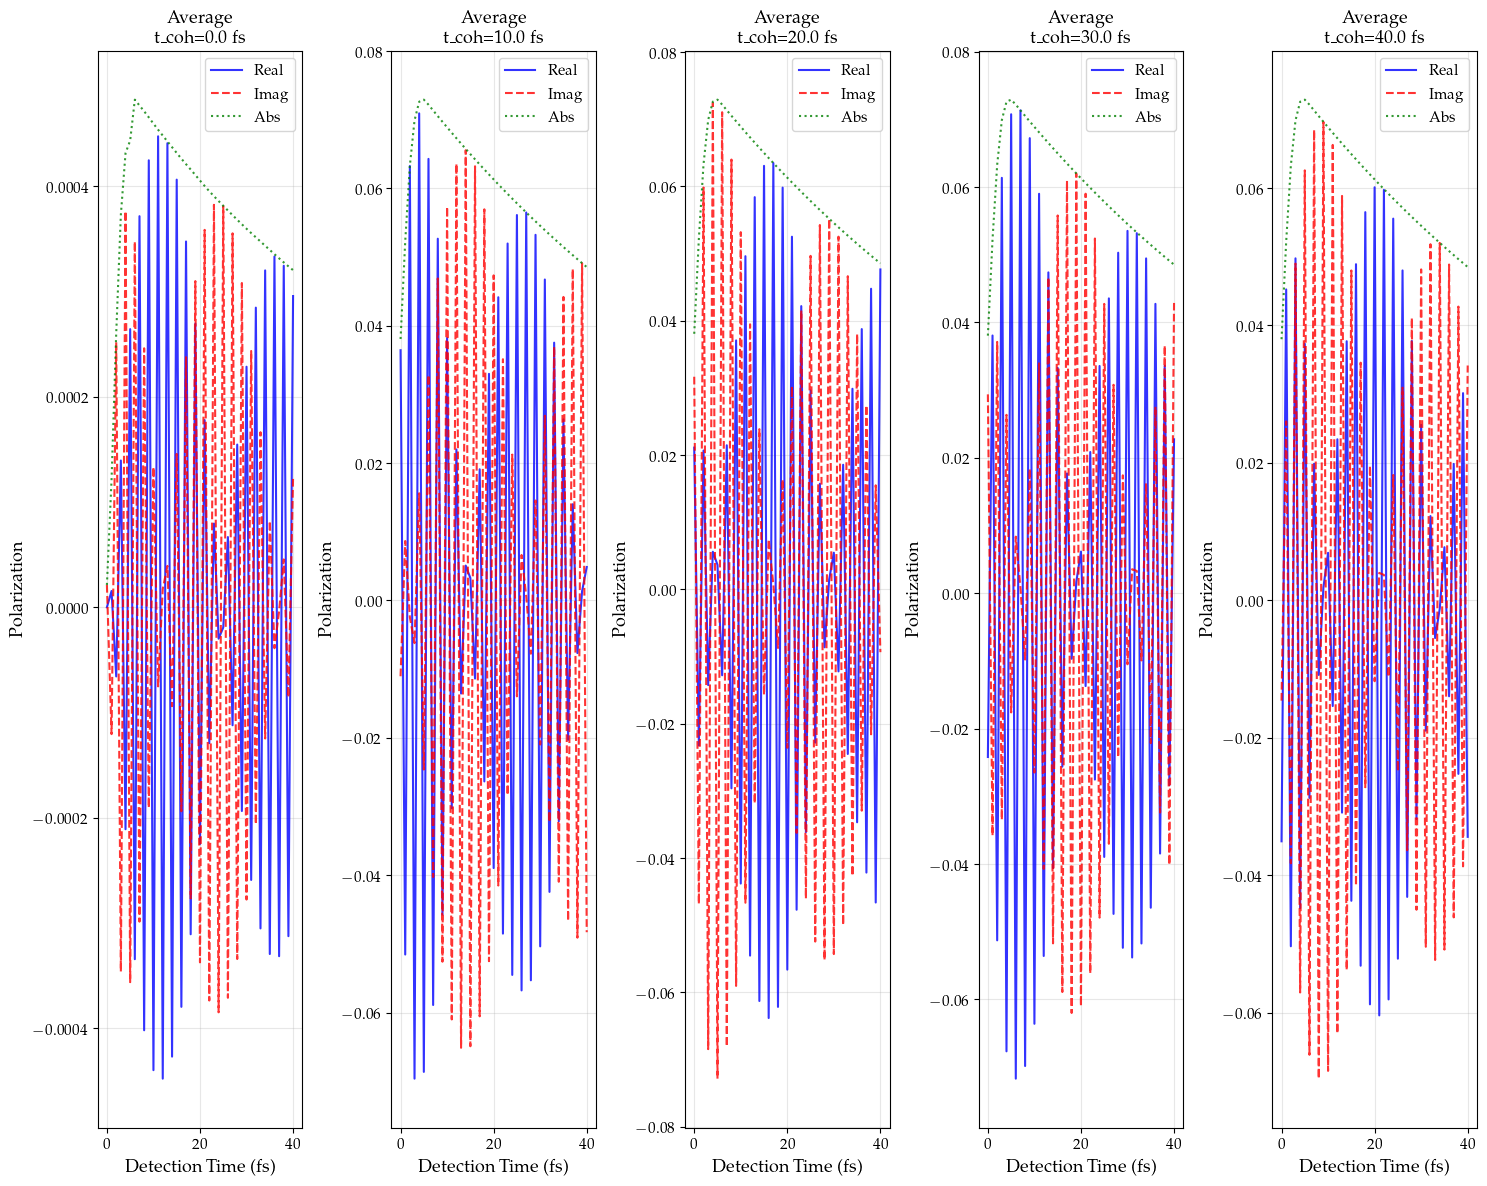

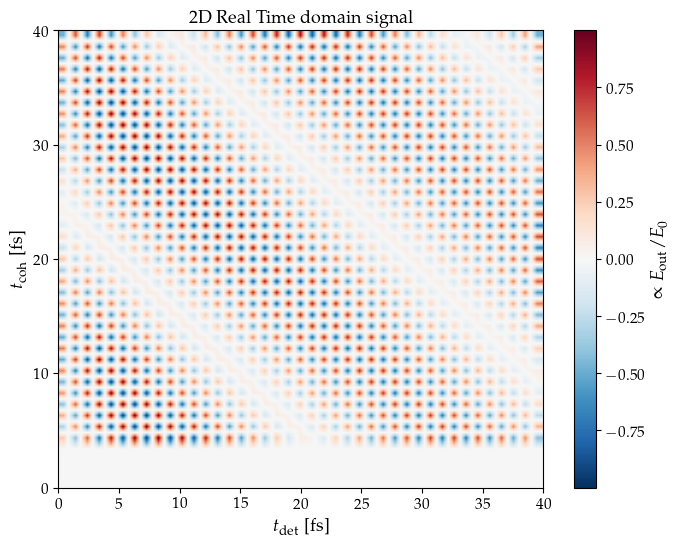

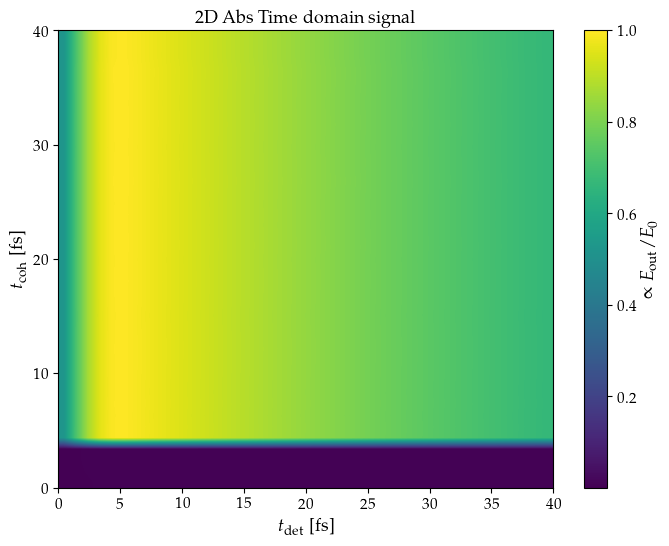

Transforming 2D time-domain data to frequency domain...
Frequency domain spectrum shape: (41, 41)
Detection wavenumber range: [-1.6, 1.6] × 10^4 cm⁻¹
Coherence wavenumber range: [-1.6, 1.6] × 10^4 cm⁻¹
Plotting 2D frequency-domain spectrum...


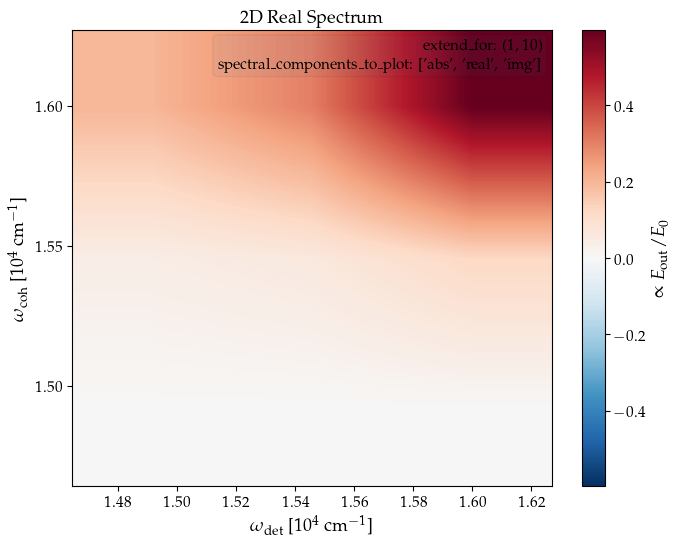

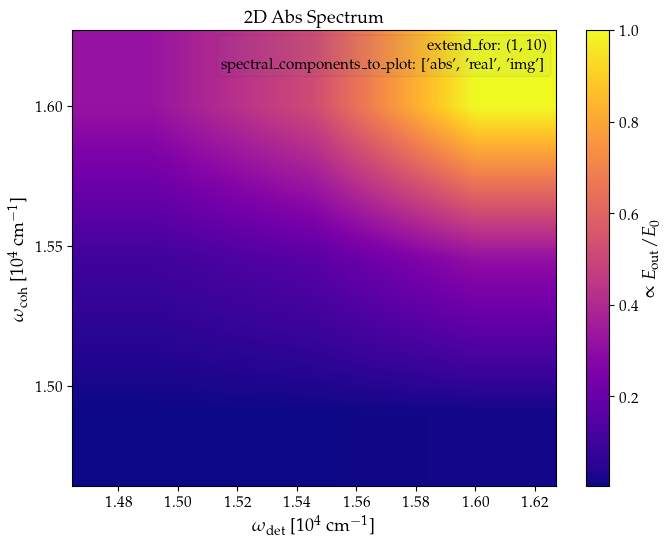

2D frequency-domain spectrum computed and visualized.


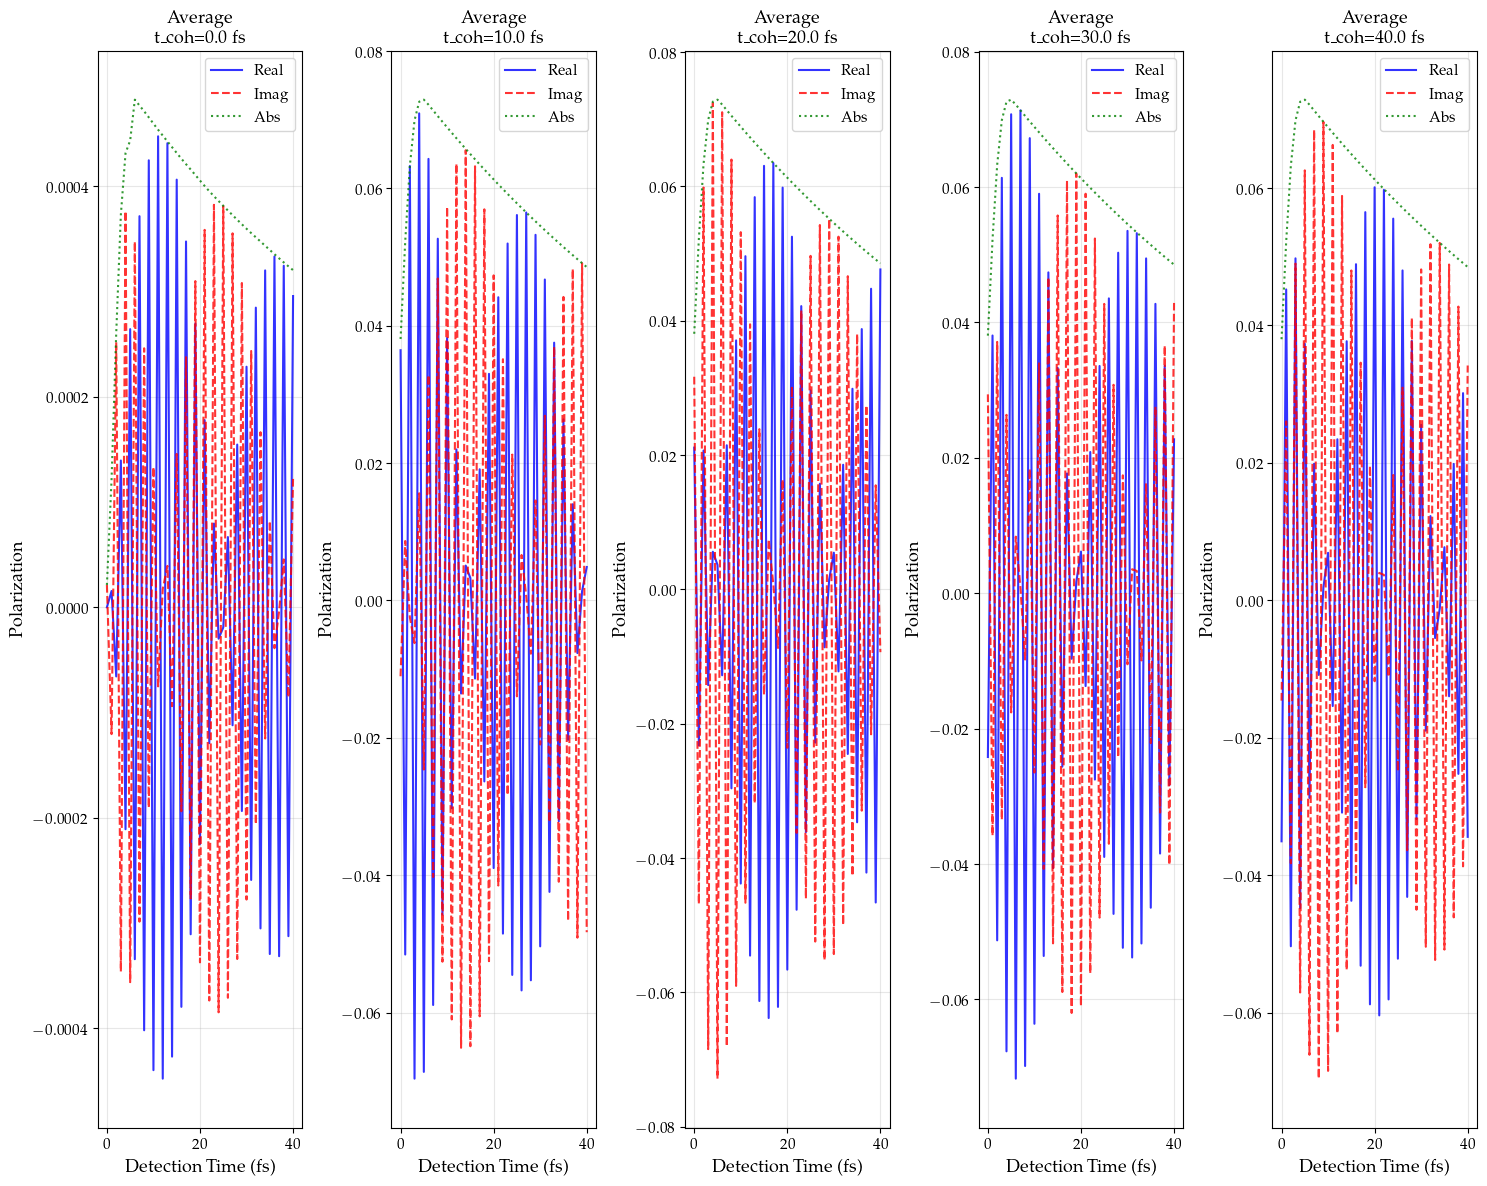

In [16]:
# STEP 3b-2D: Extract IFT signal components for multiple coherence times
print("Extracting IFT signal components for 2D simulation...")

# Extract signal components for each t_coh
for t_coh in t_coh_range:
    results_matrix = results_matrices_2d[t_coh]
    signal_components = extract_P_lmn_1d(results_matrix, sim_oqs)
    signal_components_2d[t_coh] = signal_components

print(f"Extracted signal components for {len(signal_components_2d)} coherence times")

# Organize data for 2D plotting
signal_types = sim_oqs.simulation_config.signal_types
n_t_coh = len(t_coh_range)
n_t_det = len(_times_det)

# Create 2D arrays: (t_coh, t_det) for each signal type
data_2d = {}
for sig_type in signal_types:
    data_2d[sig_type] = np.zeros((n_t_coh, n_t_det), dtype=complex)
    for i, t_coh in enumerate(t_coh_range):
        data_2d[sig_type][i, :] = signal_components_2d[t_coh][sig_type]

print(f"Created 2D data arrays with shape ({n_t_coh}, {n_t_det}) for signal types: {list(data_2d.keys())}")

# Visualize signal components at a few coherence times
fig_components_2d = plt.figure(figsize=(15, 12))
sample_indices = [0, len(t_coh_range)//4, len(t_coh_range)//2, 3*len(t_coh_range)//4, -1]

for j, sig_type in enumerate(signal_types):
    for i, idx in enumerate(sample_indices):
        plt.subplot(len(signal_types), len(sample_indices), j*len(sample_indices) + i + 1)
        
        t_coh_sample = t_coh_range[idx]
        component_data = data_2d[sig_type][idx, :]
        
        plt.plot(_times_det, np.real(component_data), 'b-', label='Real', alpha=0.8)
        plt.plot(_times_det, np.imag(component_data), 'r--', label='Imag', alpha=0.8)
        plt.plot(_times_det, np.abs(component_data), 'g:', label='Abs', alpha=0.8)
        
        plt.xlabel('Detection Time (fs)')
        plt.ylabel('Polarization')
        plt.title(f'{sig_type.capitalize()}\nt_coh={t_coh_sample:.1f} fs')
        plt.legend()
        plt.grid(True, alpha=0.3)

plt.tight_layout()
display(fig_components_2d)

# Show 2D contour plot for one signal type using plot_2d_el_field
if signal_types:
    primary_sig = signal_types[0]
    
    # Plot real part
    fig_2d_real = plot_2d_el_field(
        _times_det, 
        t_coh_range, 
        data_2d[primary_sig], 
        domain='time', 
        component='real',
    )
    display(fig_2d_real)
    
    # Plot absolute value
    fig_2d_abs = plot_2d_el_field(
        _times_det, 
        t_coh_range, 
        data_2d[primary_sig], 
        domain='time', 
        component='abs',
    )
    display(fig_2d_abs)

# STEP 5: Transform to frequency domain using compute_2d_fft_wavenumber
from qspectro2d.spectroscopy.post_processing import compute_2d_fft_wavenumber

print("Transforming 2D time-domain data to frequency domain...")

# Prepare data for FFT - convert dictionary to list in correct order
data_list = [data_2d[sig] for sig in signal_types]

# Compute 2D FFT
nu_dets, nu_cohs, spectrum_2d = compute_2d_fft_wavenumber(
    t_dets=_times_det,
    t_cohs=t_coh_range,
    datas=data_list,
    signal_types=signal_types
)

print(f"Frequency domain spectrum shape: {spectrum_2d.shape}")
print(f"Detection wavenumber range: [{nu_dets.min():.1f}, {nu_dets.max():.1f}] × 10^4 cm⁻¹")
print(f"Coherence wavenumber range: [{nu_cohs.min():.1f}, {nu_cohs.max():.1f}] × 10^4 cm⁻¹")

# Plot the 2D frequency-domain spectrum
print("Plotting 2D frequency-domain spectrum...")
plot_config = {
    # "plot_time_domain": True,
    "extend_for": (1, 10),
    "spectral_components_to_plot": ["abs", "real", "img"],
    # "section": [(1, 3), (1, 3)],
    "section": [(1.4, 1.8), (1.4, 1.8)],
}

# Plot real part in frequency domain
fig_2d_freq_real = plot_2d_el_field(
    nu_dets, 
    nu_cohs, 
    spectrum_2d, 
    domain='freq', 
    component='real',
    **plot_config
)
display(fig_2d_freq_real)

# Plot absolute value in frequency domain
fig_2d_freq_abs = plot_2d_el_field(
    nu_dets, 
    nu_cohs, 
    spectrum_2d, 
    domain='freq', 
    component='abs',
    **plot_config

)
display(fig_2d_freq_abs)

print("2D frequency-domain spectrum computed and visualized.")